# Theory kernel analysis: a method to evaluate action unit based theories of emotional facial expression perception
*Lukas Snoek, Suzanne Oosterwijk, H. Steven Scholte, Rachael Jack, & Philippe Schyns*

This notebook describes how "theory kernels" can be used to formalize and quantify action-unit based theories. It primarily meant as a demonstration of the method and to showcase some preliminary results (i.e., not as a paper draft).

**To do**:
* Check consistency terminology (theory, class, vector)
* Results per intensity quantile

## 1. Introduction
The face, and dynamic facial expressions, is a powerful and efficient medium to express and transmit internal cognitive and affective states, and has arguably been formally investigated most often in the context of emotion experience and perception. Since the pioneering work by Paul Ekman (ref), researchers have tried to describe and quantify how, on the one hand, affective states generate facial expressions and, on the other hand, how affective states are inferred from facial expressions. Central to this endeavor are "action units" &mdash (groups of) muscles that realize different facial movements. Previous studies have shown that experience of different (categorical) emotions reliably (?) activate specific configurations of action units (ref, ref, ref). Similarly, other studies have shown that specific configurations of action units reliably lead to the perception of different categorical emotions. However, there is no full agreement about the exact mapping between emotion (both in terms of experience and perception) and action units. Since Ekman, there have been many different "theories" about this mapping. These theories, while often supported by quantitative analyses, are limited in their value as a *model* of emotion perception. In this study, we develop a novel way to quantify such action unit based theories of emotional facial expression perception, which we call "theory kernel analysis".

### Action unit based theories of emotional facial expression perception
* Discuss the idea of emotion generation == emotion perception (with caveats), cf. Darwin
* Summarize/discuss different theories and how they come about (reverse correlation, etc.)
* Note that this study is limited to *perception*

### What's in a model?
* A model is quantitative; allows for prediction of new data
* May or may not contain (to-be-estimated) parameters

### Current study
* reiterate idea in more detail

## 2. Methods

### 2.1. The proposed method
To evaluate AU-based theories of emotional facial expression perception, we propose to formalize those theories as points in "AU space". Subsequently, using discrete emotion ratings of facial expression stimuli with known AU configurations, we can embed those stimuli in the same AU space and derive quantitative emotion predictions based on their distance &mdash; computed using a *kernel function* &mdash; to the points representing the different theories. Finally, these predictions can be evaluated by comparing them to actual emotion ratings from human participants.

    *Figure with (conceptual) visualization of method*

As such, our proposed analysis involves four elements: the encoding of theories in AU space, the encoding of stimuli in AU space, a kernel function to generate predictions, and a metric to summarize accuracy of the theory, which are discussed in turn below.

#### 2.1.1. Encoding theories
An important concept in our method is the embedding of AU theories (and stimuli with known AU configurations, discussed in the next subsection) into $D$-dimensional numerical vectors, which represent hypotheses of how AU configurations map onto categorical emotions. To explain this concept, suppose that for simplicity we are dealing with theories that are based on a limited set of 10 AUs outlined below:

\begin{align}
\mathrm{AU} = \{\mathrm{AU}1, \mathrm{AU}2, \mathrm{AU}4, \mathrm{AU}5, \mathrm{AU}6, \mathrm{AU}7, \mathrm{AU}9, \mathrm{AU}12, \mathrm{AU}15, \mathrm{AU}26\} 
\end{align}

In code:

In [1]:
# {*} is a set in Python
AU = {'AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU12', 'AU15', 'AU26'}

In other words, in this example, we are dealing with a 10-dimensional AU space ($D=10$). Now, assume that a particular theory, $T$, suggests that humans express the categorical emotion "happiness" using a combination of AU12 and AU6 (the "Duchenne smile"). Within our 10-dimensional AU space, we can create a binary 10-dimensional vector containing ones at positions associated with AUs that are hypothesized to be used in displaying happiness and zeros elsewhere:

\begin{align}
T_{\mathrm{happy}} =
\begin{bmatrix}
0, 0, 0, 0, 1, 0, 0, 1, 0, 0
\end{bmatrix}
\end{align}

Let's also implemented this in code as a 10D row vector:

In [2]:
import numpy as np
T_happy = np.array([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]])
print(T_happy.shape)

(1, 10)


Note that, in the above example, values at the positions of hypothesized AUs are all coded 1, which implies that each AU contributes equally to that emotions configuration. This does not have to be the case, however. If, for example, a particular theory hypothesizes that a particular emotion maps onto a combination of AU1 and AU2, but AU1 is thought to be twice as important as AU2, then its theory vector can be constructed as follows: 

\begin{align}
T_{e} = \begin{bmatrix} 1, .5, 0, 0, 0, 0, 0, 0, 0, 0 \end{bmatrix}
\end{align}

For simplicity, we assume in this example that each hypothesized AU is equally important (such that theory vectors are binary). Importantly, often, theories hypothesize mappings onto multiple (categorical) affective states ($M$), which we will refer to as *classes*. Here, we assume that our hypothetical theory $T$ limits its mappings to the six basic emotions (i.e., $M = 6$). Specifically, suppose that theory $T$ also hypothesizes specific AU-emotion mappings for the following categorical emotions:

* anger: AU4, AU5, AU7
* disgust: AU9, AU15
* fear: AU1, AU2, AU4, AU7, AU26
* sadness: AU1, AU4, AU15
* surprise: AU1, AU2, AU5, AU26

Accordingly, we can encode the entire set of AU-emotion mappings for a given theory with $M$ classes and $D$ dimensions into a $M \times D$ matrix, effectively vertically stacking the $M$ different row vectors. For our hypothetical theory $T$, its associated "theory matrix" would look like the following:

\begin{align}
T = 
\begin{bmatrix}
0, 0, 1, 1, 0, 1, 0, 0, 0, 0 \\
0, 0, 0, 0, 0, 0, 1, 0, 1, 0 \\
1, 1, 1, 0, 0, 1, 0, 0, 0, 1 \\
0, 0, 0, 0, 1, 0, 0, 1, 0, 0 \\
1, 0, 1, 0, 0, 0, 0, 0, 1, 0 \\
1, 1, 0, 1, 0, 0, 0, 0, 0, 1 \\
\end{bmatrix}
\end{align}

where its rows represent the different classes (emotions):

\begin{align}
E = \{\mathrm{Anger}, \mathrm{Disgust}, \mathrm{Fear}, \mathrm{Happiness}, \mathrm{Sadness}, \mathrm{Surprise}\}
\end{align}

In [3]:
E = {'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'}

Although the above represents a hypothetical theory, its sparsity is something we would expect, as facial expressions are unlikely to be generated by a full (dense) set of action units. Again, let's implement this construct as a 2D array:

In [4]:
# We use Th instead of T to prevent confusion with an array's transpose (.T)
Th = np.array([
    [0, 0, 1, 1, 0, 1, 0, 0, 0, 0],  # anger
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],  # disgust
    [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],  # fear
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # happiness
    [1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # sadness
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 1]   # surprise
])
print(Th.shape)

(6, 10)


#### 2.1.2. Encoding stimuli
In order to evaluate AU-based theories of emotional facial expression perception, we need to evaluate how well these theories are able to predict actual categorical emotion ratings of human participants on stimuli with known AU configurations. Ideally, these theories are evaluated using data from experiments that sample as much as possible of the AU space. Many experiments on emotional facial expression perception, however, use posed and stereotyped stimuli (e.g., facial expressions of extreme joy or anger), which cover only a small part of the entire AU space and thus do not allow for unbiased evaluation of AU-based theories. In contrast, AU-focused psychophysics experiments, which are characterized by randomly and parametrically varying the input space (defined by AU configurations) and collection of resulting percepts (here: perception of categorical emotion) do not impose such contraints (ref Jack).

Now, assume there is such psychophysics-style data available, i.e., that we have a set of $N$ stimuli $\mathbf{S}_{1 \dots N}$, generated with random AU configurations (drawn from the previously defined set $\mathrm{AU}$), with associated categorical emotion labels $\mathbf{e}_{1 \dots N} \in E$. The next step in our analysis is to encode these stimuli in AU space in the same way we did for the hypothetical theory. To do so, we need to assume that each stimulus, $S_{i}$, was generated with one or more AUs drawn from the same set that was used to encode the theories in AU space. Then, we can create for each stimulus $S_{i}$ an associated $D$-dimensional binary stimulus vector containing nonzero values at positions associated with active AUs for that stimulus and zeros elsewhere. Note that, the nonzero values at positions associated with active AUs can be all ones (if assumed to be equally "active") or be values proportional to the amplitude (or "activity") of the active AUs.

For example, suppose that stimulus $S_{i}$ contains AU1, AU5, and AU26 which were actived with amplitudes 0.1, 0.5, and 0.8. Then, formally, we can represent this particular stimulus, $S_{i}$, as a 10-dimensional vector:

\begin{align}
S_{i} = 
\begin{bmatrix}
0.1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.8
\end{bmatrix}
\end{align}

Let's also define this as an actual vector:

In [5]:
S_i = np.array([[0.1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.8]])

Given that both our theories ($T$) and stimuli ($\mathbf{S}$) are encoded as vectors in $D$-dimensional AU space, we can discuss using *kernels* to generate quantitative predictors for stimuli given a particular theory.

#### 2.1.3. Kernel functions
Within our theory kernel analysis framework, *kernel functions* (of called just *kernels*) are functions that are, broadly speaking, measures of similarity between two vectors. Applied to our usecase, we use kernel functions ($k$) to quantify the similarity ($\phi$) between a stimulus with a known action unit configuration ($S_{i}$) and a theory vector for a specific emotion, $j$ ($T_{j}$, e.g., happiness): 

\begin{align}
\phi_{i,j} = k(S_{i}, T_{j})
\end{align}

Most (linear) kernel functions are based on the dot (inner) product of the theory vector ($T_{j}$) and the stimulus vector ($S_{i}$). In fact, a "linear kernel" is just this:

\begin{align}
k(S_{i}, T_{j}) = S_{i}T^{T}_{j}
\end{align}

(But more complicated kernels exist, like the "sigmoid kernel": $\tanh(\gamma S_{i}^{T}T_{j} + c_{0}$).)

Implementing a linear kernel is as simple as a dot (inner) product:

In [6]:
j = 0  # anger
phi_ij = np.squeeze(S_i @ Th[j, :].T)
print(f"Similarity between S_i and T_{j}: {phi_ij}")

Similarity between S_i and T_0: 0.5


Note that the absolute magnitude of the similarity to a given class $j$ is not necessarily interpretable, but should be interpreted relative to the similarities to the other classes. To compute the similarity for all classes ($j = 1 \dots M$), one extend the kernel to compute the similarity between a stimulus vector ($S_{i}$) and a full theory *matrix* ($T$):

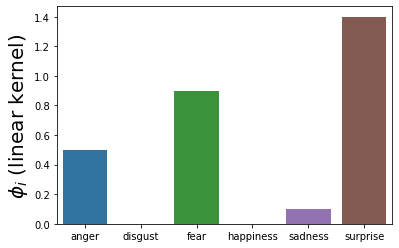

In [7]:
import seaborn as sns  # plotting lib

phi_i = S_i @ Th.T
ax = sns.barplot(sorted(list(E)), phi_i.squeeze())
ax.set_ylabel(r'$\phi_{i}$ (linear kernel)', fontsize=20);

(Similarly, the linear kernel accomodates computing the similarity for multiple stimuli, stored in an $N \times D$ stimulus *matrix*, as well.)

While the similarity to a given theory class vector is arguably proportion to the evidence for that particular class, it is not strictly speaking a *prediction*. To generate a prediction for stimulus $S_{i}$ (i.e., $\hat{e}_{i}$), one can pick the emotion ($j = 1 \dots M$) that maximizes its similarity, for some kernel function ($k$), to the stimulus:

\begin{align}
\hat{e}_{i} = \underset{j}{\operatorname{argmax}}k(S_{i}, T_{j})
\end{align}

Below, this is implemented in code by taking the argmax of the dot product (linear kernel) between the stimulus and the theory array:

In [8]:
e_hat = np.argmax(S_i @ Th.T)
print(f"Discrete prediction for S_i: {e_hat} ({sorted(list(E))[e_hat]})")

Discrete prediction for S_i: 5 (surprise)


In a slightly more sophisticated version, we can generate *probabilistic* predictions, e.g., $p(E | T, S_{i})$ by normalizing each of the $j = 1 \dots M$ similarities ($\phi_{i,j}$), to the 0-1 range using the softmax function:

\begin{align}
P(E_{j} | T, S_{i}) = \sigma(\phi_{i, j}) = \frac{e^{\beta\phi_{i, j}}}{\sum_{j=1}^{M} e^{\beta\phi_{i, j}}}
\end{align}

where $\beta$ is the "inverse temperature" parameter &mdash; a scaling parameter &mdash; which distributes relatively more mass onto the largest values. In our framework, we can treat this parameter as a model hyperparameter (i.e., a parameter that is not fit, but manually tuned using cross-validation).

It is implemented as follows:

In [9]:
def softmax(phi, beta):
    """ Softmax function with inverse temperature (beta) parameters.
    
    Parameters
    ----------
    phi : array
        Similarities for M classes
    beta : int/float
        Inverse temperature parameter
        
    Returns
    -------
    p : array
        Probabilities for M classes
    """
    bphi = beta * phi
    # max value is subtracted to prevent overflow
    p = np.exp(bphi - np.max(bphi)) / np.sum(np.exp(bphi - np.max(bphi)))
    
    # Get rid of singleton dimension, if there is one
    if p.shape[0] == 1:
        p = np.squeeze(p)

    return p

Applying it to our hypothetical stimulus vector $S_{i}$, with different values for $\beta$ (i.e., 1 and 3) gives the following discrete probability distributions across emotions:

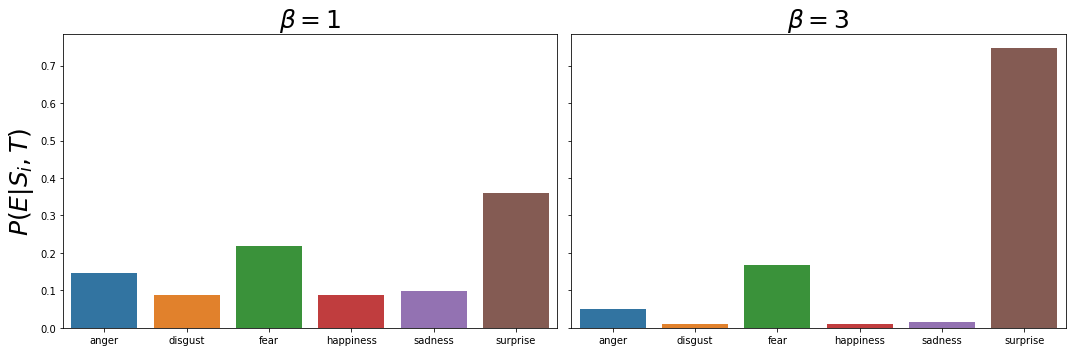

In [10]:
import matplotlib.pyplot as plt

# Get probs for two different betas
p_b1 = softmax(S_i @ Th.T, beta=1)
p_b3 = softmax(S_i @ Th.T, beta=3)

# Plot both prob. distributions
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.barplot(x=sorted(list(E)), y=p_b1, ax=axes[0])
axes[0].set_ylabel(r"$P(E | S_{i}, T)$", fontsize=25)
axes[0].set_title(r"$\beta = 1$", fontsize=25)
sns.barplot(x=sorted(list(E)), y=p_b3, ax=axes[1])
axes[1].set_title(r"$\beta = 3$", fontsize=25)
fig.tight_layout()

Note that increasing the $\beta$ parameter forces more mass onto the class with the highest similarity. Indeed, in the limit, a softmax with an infinite inverse temperature parameter yields a discrete predictor (argmax across the similarity scores).

As a side note: instead of the softmax function, you could also use a simple linear probability normalization function (instead of an exponential one like the softmax function): $P(E_{j} | T, S_{i}) = \frac{\phi_{i, j}}{\sum_{j=1}^{M} {\phi_{i, j}}}$. In practice, this does not yield any performance improvement over softmax normalization, and because the latter is standard practice in many models (e.g., multinomial logistic regression), we stick with softmax normalization for our analyses.

#### 2.1.4. Quantifying theory accuracy
To evaluate each theory, we can compare their (discrete or probabilistic) predictions for a set of stimuli with data from participants who actually rated those same stimuli in terms of perceived emotion. In other words, we can quantitatively assess how well the theoretical predictions match with actual behavior.

In our analyses, we used the "area under the curve of the receiver operating characteristic" (AUROC) which summarizes the quality of probabilistic predictions in a range from 0 to 1, where 0.5 is chance level performance and 1 is a perfect prediction. For example, suppose we have the following stimuli:

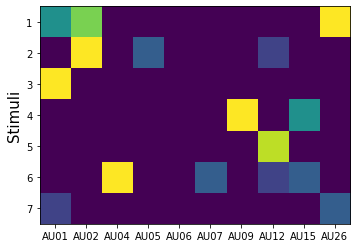

In [11]:
S = np.array([
    [.5, .8, 0., 0., 0., 0., 0., 0., 0., 1.],  # disgust
    [0., 1., 0., .3, 0., 0., 0., .2, 0., 0.],  # surprise?
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # sadness
    [0., 0., 0., 0., 0., 0., 1., 0., .5, 0.],  # happy
    [0., 0., 0., 0., 0., 0., 0., .9, 0., 0.],  # fear
    [0., 0., 1., 0., 0., .3, 0., .2, .3, 0.],  # anger
    [.2, 0., 0., 0., 0., 0., 0., 0., 0., .3]   # disgust
])

# Let's plot it as a "heatmap"
plt.imshow(S)
plt.xticks(range(S.shape[1]), sorted(list(AU)))
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel("Stimuli", fontsize=15);

And suppose those stimuli, for a given participant, were rated with the following emotions:

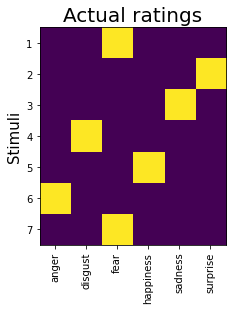

In [12]:
# e_lab = emotion LABels
e_lab = ['fear', 'surprise', 'sadness', 'disgust', 'happiness', 'anger', 'disgust']

# e_int = emotion INTegers
e_int = np.array([2, 5, 4, 1, 3, 0, 2])

# "One-hot encode" ratings
e_int = np.vstack([np.arange(6) == ei for ei in e_int]).astype(int)

# Let's plot it as a heatmap
plt.imshow(e_int)
plt.title("Actual ratings", fontsize=20)
plt.xticks(range(6), sorted(list(E)), rotation=90)
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel('Stimuli', fontsize=15);

To get our predictions, we compute the similarity between each stimulus and each class in our theory matrix ($T$), which are subsequently normalized using the softmax function:

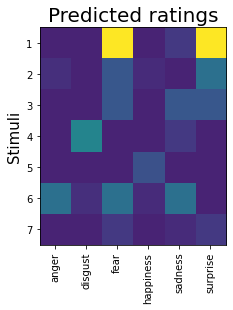

In [13]:
e_hat = softmax(S @ Th.T, beta=1)
plt.imshow(e_hat, vmin=0, vmax=e_hat.max())
plt.title("Predicted ratings", fontsize=20)
plt.xticks(range(6), sorted(list(E)), rotation=90)
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel('Stimuli', fontsize=15);

Finally, to evaluate how "good" these predictions are, we will use the AUROC score, which will by default (in *scikit-learn*'s implementation) yield the class-average AUROC score:

In [14]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(e_int, e_hat)

But we can also get the score *per class* (i.e., per emotion):

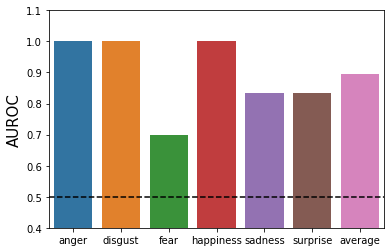

In [15]:
score_per_class = roc_auc_score(e_int, e_hat, average=None)

# Let's plot all scores (average and class-specific)
ax = sns.barplot(sorted(list(E)) + ['average'], np.append(score_per_class, score))
ax.axhline(0.5, ls='--', c='k')
ax.set_ylabel('AUROC', fontsize=15)
ax.set_ylim(0.4, 1.1);

### 2.2. Noise ceiling estimation
Suppose that, for a given dataset, we find that our theory kernel analysis yields a (class-average) AUROC score of 0.8 &mdash; what can and should be conclude from this score? It is certainly above chance level (a score of 0.5) but also substantially below perfect performance (i.e., a score of 1). Here, we argue that one should not interpret performance relative to a theoretical maximum score, but relative to a *noise ceiling* &mdash; a concept borrowed from systems neuroscience (ref, ref) &mdash; which represents an upper bound that incorporates the between-subject variance in ratings. In other words, a noise ceiling is a way to estimate an upper bound for predictive models that is adjusted for "consistency" or "measurement error" across subjects.

    *figure with visualization of noise ceiling estimation*

While noise ceilings are routinely used in systems and cognitive neuroscience, existing methods for estimating noise ceilings are limited to regression models (assuming a continuous target variable, usually some type of brain measurement). In the current study, however, we are dealing with *classification* models, as we are trying to predict a categorical target variable (i.e., categorical emotion ratings). Here, we propose a novel approach to estimate a noise ceiling for predictive performance of classification models.

An crucial and necessary element for noise ceiling estimation is the availability of *repeated observations*, because variance (or, inversely, the "consistency") between repeats is used for estimation. In this study, we can conceptualize the ratings of the same set of trials across subjects as repeated observations (e.g., twelve participants ratings the same stimulus $S_{i}$ counts as twelve repetitions of that trial). (Note that this type of "between-subject" noise ceiling can also be applied to within-subject models, which needs stimulus repeats.)

To make this more clear, suppose that there are three subjects who all rated the same stimuli ($S_{1}, S_{2}, \dots, S_{N}$). For now, we'll restrict this example to only two stimuli ($S_{1}$ and $S_{2}$). The first stimulus ($S_{1}$) was rated as "surprise" by subject 1, but as "disgust" by subject 2 and 3. Conversely, the second stimulus ($S_{2}$) was rated as "disgust" by participant 1 and 2, but as "surprise" by subject 3.

In code:

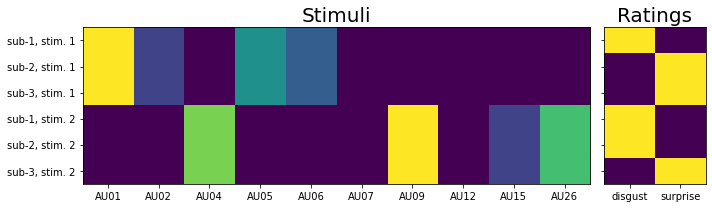

In [16]:
n_sub = 3
n_trial = 2

# best: surprise, second best: disgust
S1 = np.array([1., .2, 0., .5, .3, 0., 0., 0., 0., 0.])

# best: disgust, second best: surprise
S2 = np.array([0., 0., .8, .0, 0., 0., 1., 0., .2, 0.7])

# Repeat stimulus 3 times
S = np.vstack((
    np.tile(S1, n_sub).reshape(n_sub, 10),
    np.tile(S2, n_sub).reshape(n_sub, 10),
))

trial_idx = np.repeat(range(n_trial), n_sub)

e = np.array([0, 1, 1, 0, 0, 1])
# One-hot-encoded
e = np.vstack([np.arange(2) == ei for ei in e]).astype(int)

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3),
                         gridspec_kw={'width_ratios':[10, 2]})

axes[0].imshow(S, aspect='auto')
axes[0].set_xticks(range(S.shape[1]))
axes[0].set_xticklabels(sorted(list(AU)))
axes[0].set_yticks(range(S.shape[0]))
ytk = [f'sub-{s+1}, stim. {i+1}' for i, s in
       zip(np.repeat(range(n_trial), n_sub), np.tile(range(n_sub), n_trial))]
axes[0].set_yticklabels(ytk)
#axes[0].set_ylabel("Subjects", fontsize=15);
axes[0].set_title("Stimuli", fontsize=20)

axes[1].imshow(e, aspect='auto')
axes[1].set_xticks(range(e.shape[1]))
axes[1].set_xticklabels(['disgust', 'surprise'])
axes[1].set_yticks(range(e.shape[0]))
axes[1].grid(which='minor')
axes[1].set_title("Ratings", fontsize=20)

fig.tight_layout()

In order to establish an upper bound, we need to derive the *optimal* prediction a classifier can make, given that it should make *the same* prediction for each repeated trial/stimulus. In case of discrete predictions, this is the mode (i.e., most often occuring) of the ratings per stimulus. In our example, that would be "surprise" for stimulus 1 and "disgust" for stimulus 2. Deriving an optimal discrete prediction becomes more complicated when there is no unique mode, however. An alternative which avoids having to deal with "ties" is to use probabilistic predictions as discussed before. Here, the optimal prediction is computed as the proportion of ratings for each class (for a given stimulus). For example, in 

In [17]:
e_opt = np.zeros_like(e, dtype=float)
for t in range(n_trial):
    idx = trial_idx == t
    counts = np.bincount(e[idx, :].argmax(axis=1))
    e_opt[idx, :] = counts / counts.sum()
    
nc = roc_auc_score(e, e_opt, average=None)
print(f"Noise ceiling: {nc.round(3)}")

Noise ceiling: [0.667 0.667]


Now, we can compute the noise ceiling as the performance (for a given metric) of our model using these optimal predictions:

\begin{align}
\mathrm{noise\ ceiling} = \mathrm{score}(e, e_{\mathrm{opt}})
\end{align}

As expected, the noise ceiling reflects the proportion of trials that match the most frequent class label (i.e., disgust). 

In [18]:
idx = e.sum(axis=0) != 0
e_opt[:, idx]

array([[0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333]])

Note, however, that the term *noise* ceiling is perhaps misleading, as it suggests that any observed between-subject variance is *irreducible noise*.

### 2.3. Evaluated theories
Many action unit based theories of emotion (perception) have been put forward, but in this study we assessed those summarized in the article by [Barrett and colleagues (2019)](https://journals.sagepub.com/doi/full/10.1177/1529100619832930). Additionally, we included the Ekman configuration (2002; taken from [Clark et al., 2020](https://www.frontiersin.org/articles/10.3389/fpsyg.2020.00920/full), Table 3). So, in total, we evaluated six hypothesized sets of action unit configurations ("theories", for simplicity):

* Darwin
* Matsumoto 2008
* Keltner 2009
* Cordaro 2008 (ref)
* Cordaro 2008 (IPC)
* Ekman (2002)

Each theory postulates one or more AU configurations per emotion. We encoded these configurations in a nested dictionary as shown below:

In [20]:
import sys
sys.path.append('../src')
from theories import THEORIES

# A dictionary with theories
print(f"THEORIES contains the following theories:\n{list(THEORIES.keys())}")

THEORIES contains the following theories:
['Darwin', 'Matsumoto2008', 'Keltner2019', 'Cordaro2008ref', 'Cordaro2008IPC', 'Ekman']


Each theory contains configurations for different emotions:

In [21]:
# let's take Keltner2019 as an example
print(f"There are configurations for the following emotions:\n{list(THEORIES['Keltner2019'].keys())}")

There are configurations for the following emotions:
['happiness', 'sadness', 'surprise', 'fear', 'anger', 'disgust']


And these configurations consist of a list of AUs that are hypothesized to be indicative of a particular emotion:

In [22]:
for emo in THEORIES['Keltner2019']:
    print(f"{emo}: {THEORIES['Keltner2019'][emo]}")

happiness: ['AU06L', 'AU06R', 'AU07L', 'AU07R', 'AU12L', 'AU12R', 'AU25', 'AU26']
sadness: ['AU01', 'AU04', 'AU06L', 'AU06R', 'AU15', 'AU17']
surprise: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU25', 'AU26']
fear: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU07L', 'AU07R', 'AU20', 'AU25']
anger: ['AU04', 'AU05', 'AU17', 'AU23', 'AU24']
disgust: ['AU07L', 'AU07R', 'AU09', 'AU25', 'AU26']


Note that some theories contain multiple configurations for a given emotion. A prominent example is Ekman's theory, which contains up to 16 configurations for some emotions (e.g., for fear):

In [23]:
print(f"Configurations for fear in Ekman:")
for i, cfg in THEORIES['Ekman']['fear'].items():
    print(f"{i+1}: {cfg}")

Configurations for fear in Ekman:
1: ['AU01', 'AU02L', 'AU02R', 'AU04']
2: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU25']
3: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU26']
4: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU27']
5: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU25']
6: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU26']
7: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU27']
8: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05']
9: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU25']
10: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU26']
11: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU27']
12: ['AU05', 'AU20', 'AU25']
13: ['AU05', 'AU20', 'AU26']
14: ['AU05', 'AU20', 'AU27']
15: ['AU05', 'AU20']
16: ['AU20']


(We describe how we deal with these "many-to-one mappings" later.)

As described before, we can transform these configurations into $P$ dimensional binary "theory vectors". In our dataset, there are $P = 34$ different AUs. Note that originally, the stimuli in this dataset were parameterized with 42 different AUs. This original AU set, however, contained both *compound* AUs (such as *AU25-12* and *AU1-2*) and AUs that could be activated both unilaterally (left or right) and bilaterally (such as *AU12*). In order to encode these stimuli into independent values within the theory vectors, we recoded the compound AUs (e.g., activation of AU1-2 is recoded as activation of both AU1 and AU2) and bilateral AUs (e.g., activation of AU12 is recoded as activation of both AU12L and AU12R), yielding a total of 34 AUs:

In [24]:
# Load in list of theory matrices
import pandas as pd
t_df = {t: pd.read_csv(f'../data/{t}.tsv', sep='\t', index_col=0) for t in THEORIES.keys()}

# Show list of parameters
print(t_df['Darwin'].columns.tolist())

['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU06L', 'AU06R', 'AU07L', 'AU07R', 'AU09', 'AU10L', 'AU10R', 'AU11L', 'AU11R', 'AU12L', 'AU12R', 'AU13', 'AU14L', 'AU14R', 'AU15', 'AU16', 'AU17', 'AU20', 'AU20L', 'AU20R', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU38', 'AU39', 'AU43']


For example, the "Darwin" theory matrix looks as follows:

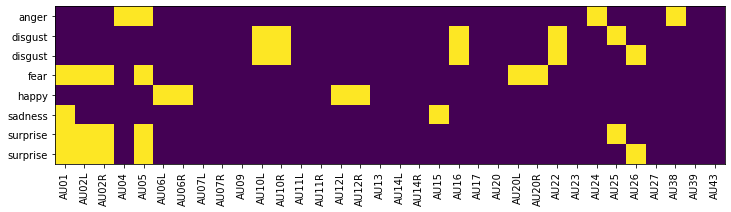

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(t_df['Darwin'])
ax.set_xticks(range(t_df['Darwin'].shape[1]))
ax.set_xticklabels(t_df['Darwin'].columns, rotation=90)
ax.set_yticks(range(t_df['Darwin'].shape[0]))
ax.set_yticklabels(t_df['Darwin'].index);

In the figure above, you can see that Darwin's theory shows multiple configurations for both disgust and surprise, which only differ in a single AU (AU25 vs. AU26).

Another way to visualize these theory matrices is to embed them as points in 2D dimensional space using a dimensionality reduction technique called *multidimensional scaling* (MDS). Specifically, using MDS, we can project the different AU configurations (i.e., rows of our theory matrices), which are 34-dimensional vectors, to points in 2D space, in which the high-dimensional (34D) distances between points are preserved as much as possible in the lower-dimensional (2D) space. This embedding (and its visualization) will prove especially helpful in interpretation of our method later.

Below, we fit the MDS algorithm on all theory matrices at the same time, but visualize the embedding per theory separately in 2D space:

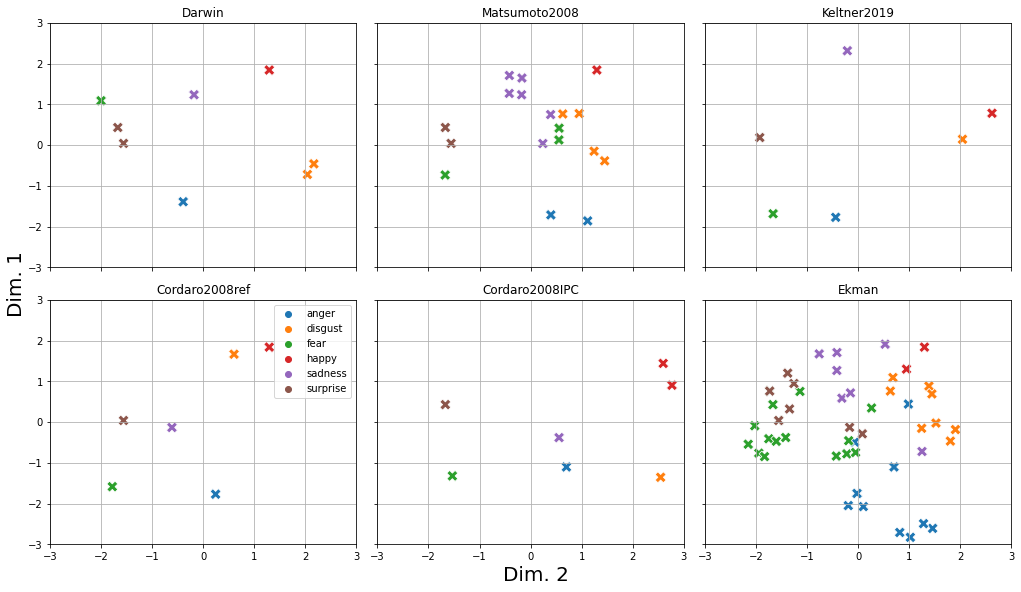

In [26]:
from sklearn.manifold import MDS
theories = list(THEORIES.keys())
idx = np.concatenate([[i] * t_df[key].shape[0] for i, key in enumerate(theories)])
mds = MDS(random_state=42)
# Fit MDS on all (i.e., concatenated) theory matrices
t_mds = mds.fit_transform(pd.concat(t_df, axis=0))

# Plot each embedding separately
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    this_mds = t_mds[idx == i, :]
    leg = 'full' if i == 3 else False
    sns.scatterplot(this_mds[:, 0], this_mds[:, 1], hue=t_df[theories[i]].index, ax=ax,
                    legend=leg, marker='X', s=120)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()
    ax.set_title(list(THEORIES.keys())[i])
    
fig.text(-0.01, 0.5, 'Dim. 1', fontsize=20, rotation=90, va='center')
fig.text(0.515, -0.015, 'Dim. 2', fontsize=20, ha='center')
fig.tight_layout();

And yet another way to visualize the relation of the different configurations is to look at their (high-dimensional) similarity (instead of looking at distances, as is done with MDS):

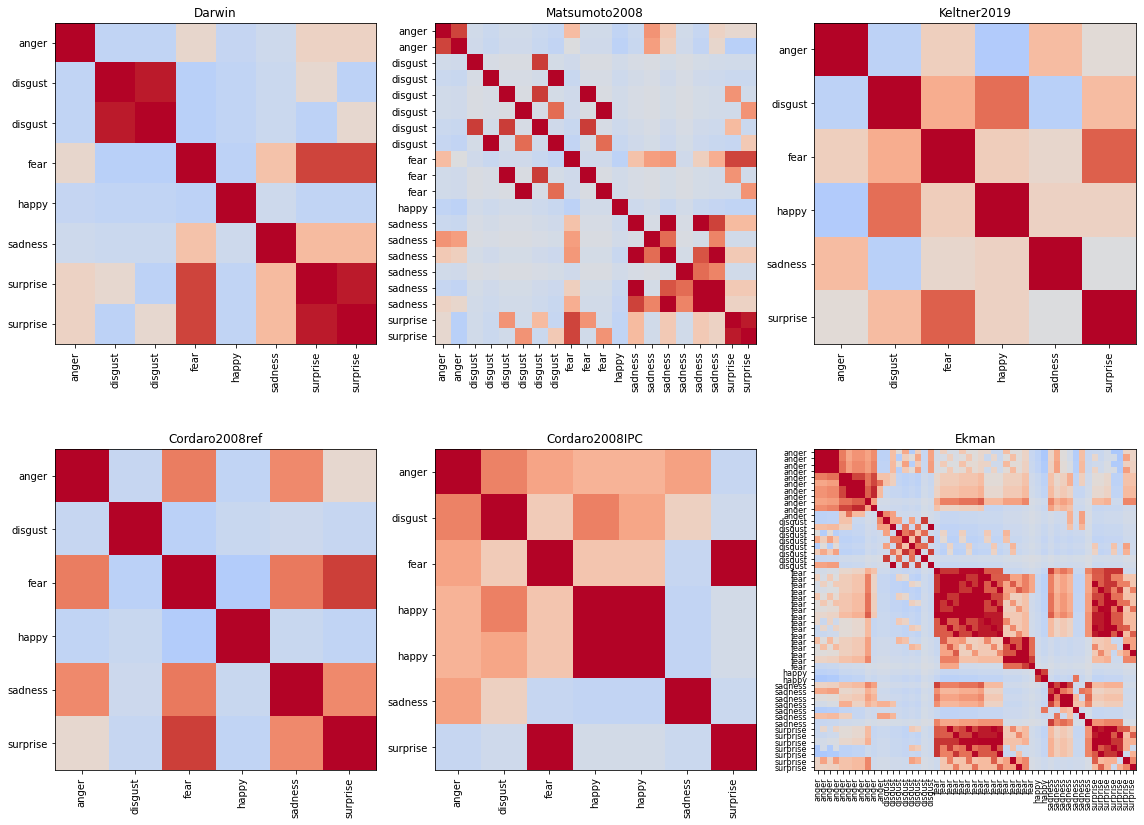

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 12))
for i, ax in enumerate(axes.flatten()):
    cor = t_df[theories[i]].transpose().corr()
    mapp = ax.imshow(cor, vmin=-0.8, vmax=0.8, cmap='coolwarm')
    fs = 8 if list(THEORIES.keys())[i] == 'Ekman' else 10
    ax.set_xticks(range(cor.shape[0]))
    ax.set_xticklabels(cor.columns, rotation=90, fontsize=fs)
    ax.set_yticks(range(cor.shape[0]))
    ax.set_yticklabels(cor.index, fontsize=fs)
    ax.set_title(list(THEORIES.keys())[i])

#fig.colorbar(mapp, ax=axes.ravel().tolist(), pad=1)
fig.tight_layout()

Although theories might postulate different configurations for a single emotion (i.e., a "many-to-one mapping"), a proper predictive model should only generate probability distribution across a fixed set of classes (e.g., the six discrete emotions in our study). Therefore, in our analyses, whenever multiple configurations are hypothesized for a given emotion, we use the highest similarity value amongst the different configurations. Formally, for $C$ different configurations for a particular emotion $E_{j}$, we use the one that yields the maximum probability $P(E_{j} | T, S_{i})$:

\begin{align}
\phi_{i,j} := \underset{c}{\operatorname{max}}\phi_{i,j | c}
\end{align}

For example, suppose that theory $T$ has 3 different configurations for anger, as demonstrated below (using hypothetical 10-dimensional AU vectors):"

In [29]:
T_anger = np.array([
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
])

Then, for a particular stimulus (e.g., $S_{i}$), we will use maximum similarity score across the $C$ configurations (here: 3):

In [30]:
np.max(S_i @ T_anger[0, :].T)

0.6

### 2.4. Data used to evaluate theories
We use data from an existing dataset from Glasgow University which contains 2400 emotion ratings of random facial expressions from 60 subjects. Specifically, each stimulus was endowed with a set of "action units" (AUs), i.e., specific facial movements, ranging in "intensity" from 0.1 to 1), randomly drawn from a full set of 34 action units. Note that these stimuli were generated with a limited set of AUs; specifically, the the number of AUs per stimulus was drawn from a binomial distribution with $n=6$ and $p=0.5$: $N_{\mathrm{AU}} \sim \mathrm{Binom}(6, .5)$.

## 3. Results

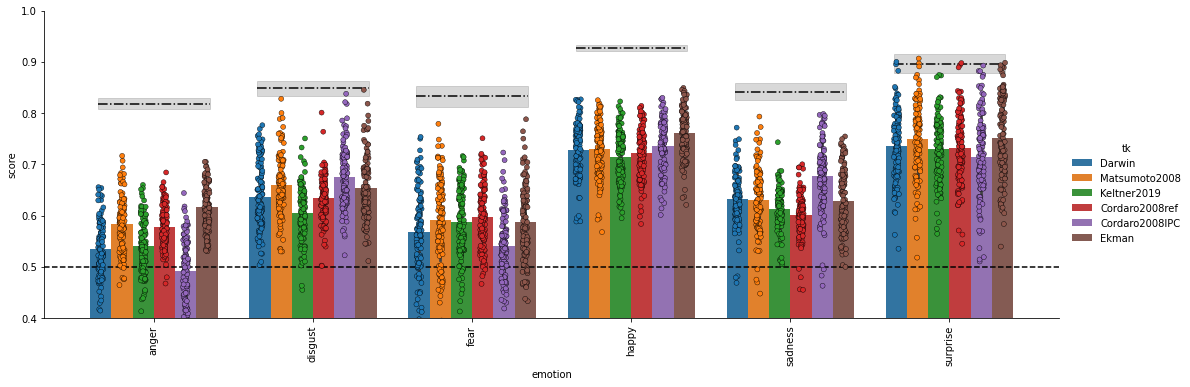

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/auroc.tsv', sep='\t', index_col=0)
nc = pd.read_csv('../data/noise_ceilings.tsv', sep='\t', index_col=0)
nc = nc.query("participant_id == 'between_subjects' & intensity == 0")

g = sns.catplot(
    x='emotion', y='score', data=df, hue='tk', kind="bar", aspect=3, height=5, ci='sd'
)
g.set_xticklabels(rotation=90)

sns.stripplot(
    x='emotion', y='score', hue='tk',
    edgecolor='black', linewidth=0.4, data=df,
    dodge=True, jitter=True
)

n_tk = df['tk'].unique().size
for i in range(6):
    this_nc = np.array([nc['noise_ceiling'].iloc[i]] * 6)
    this_sd = np.array([nc['sd'].iloc[i]] * 6)
    plt.plot(np.linspace(i-0.35, i+0.35, num=6), this_nc, c='k', ls='-.')
    plt.fill_between(
        np.linspace(i-0.35, i+0.35, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
)

ax = plt.gca()
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='--')
ax.legend_.remove()